# Multiple Linear Regression

Import necessary modules:

In [5]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.special import gamma
import preliz as pz
import matplotlib as mpl
import pymc as pm
import bambi as bmb

In [6]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (12,3)

## Credit Data

Read credit data:

In [7]:
credit_data = pd.read_csv("credit_data.csv")
credit_data.head()

,ID,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


Simple linear regression:

In [8]:
credit_model1 = bmb.Model( "Balance ~ Limit", data=credit_data, family="gaussian" )
credit_trace1 = credit_model1.fit( draws=2000, tune=2000 )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, Limit]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 6 seconds.


Default computed for conditional variable: Limit


(<Figure size 800x400 with 1 Axes>,
 array([<Axes: xlabel='Limit', ylabel='Balance'>], dtype=object))

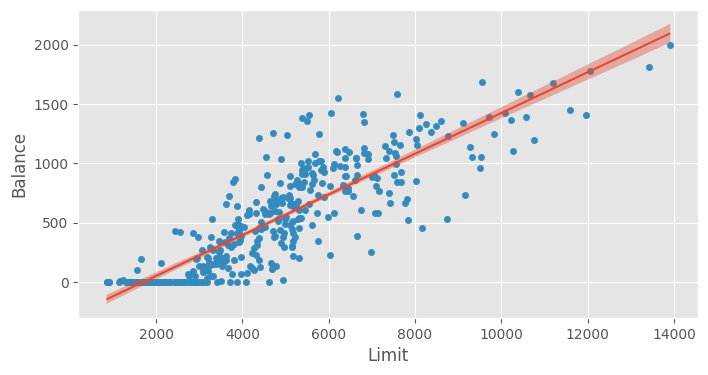

In [9]:
credit_data.plot.scatter( x="Limit", y="Balance", figsize=(8,4) )
bmb.interpret.plot_predictions( credit_model1, credit_trace1, "Limit", prob=0.9, ax=plt.gca() )

In [10]:
pm.summary( credit_trace1 )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-292.615,27.080,-340.722,-238.432,0.244,0.172,12367.0,5491.0,1.0
Limit,0.172,0.005,0.162,0.181,0.000,0.000,12382.0,6300.0,1.0
sigma,234.162,8.406,217.976,249.822,0.083,0.059,10295.0,6199.0,1.0


$R^2$ score:

In [11]:
credit_model1.predict(credit_trace1, kind="response")
ypred = az.extract( credit_trace1.posterior_predictive ).Balance.values.T
ytrue = credit_data.Balance.values
pm.r2_score( ytrue, ypred )

r2        0.659115
r2_std    0.018553
dtype: float64

## More than one variable

In [12]:
credit_data.head()

,ID,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


In [13]:
credit_model2 = bmb.Model( "Balance ~ Limit + Income", data=credit_data, family="gaussian" )
credit_trace2 = credit_model2.fit(draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, Limit, Income]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 8 seconds.


In [14]:
credit_model2

       Formula: Balance ~ Limit + Income
        Family: gaussian
          Link: mu = identity
  Observations: 400
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 520.015, sigma: 3008.889)
            Limit ~ Normal(mu: 0.0, sigma: 0.498)
            Income ~ Normal(mu: 0.0, sigma: 32.6123)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 459.1838)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

In [15]:
pm.summary( credit_trace2 )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Income,-7.654,0.384,-8.414,-6.955,0.005,0.003,6565.0,5545.0,1.0
Intercept,-384.349,19.398,-421.561,-348.736,0.210,0.149,8486.0,7132.0,1.0
Limit,0.264,0.006,0.253,0.275,0.000,0.000,6620.0,5543.0,1.0
sigma,165.907,5.822,155.568,177.213,0.067,0.048,7458.0,6073.0,1.0


In [16]:
credit_model2.predict(credit_trace2, kind="response")
ypred = az.extract( credit_trace2.posterior_predictive ).Balance.values.T
ytrue = credit_data.Balance.values
pm.r2_score( ytrue, ypred )

r2        0.793435
r2_std    0.012945
dtype: float64

Significantly more variance explained with `Income` data.

## Categorical Predictors

In [17]:
credit_data[["Balance", "Income", "Limit", "Student"]].head()

,Balance,Income,Limit,Student
0,333,14.891,3606,No
1,903,106.025,6645,Yes
2,580,104.593,7075,No
3,964,148.924,9504,No
4,331,55.882,4897,No


In [18]:
credit_model3 = bmb.Model( "Balance ~ Limit + Income + Student", data=credit_data, family="gaussian" )
credit_trace3 = credit_model3.fit(draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, Limit, Income, Student]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 10 seconds.


In [19]:
pm.summary( credit_trace3 )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Income,-7.893,0.245,-8.361,-7.437,0.003,0.002,6397.0,5326.0,1.0
Intercept,-432.067,12.492,-455.493,-408.333,0.130,0.092,9169.0,7422.0,1.0
Limit,0.267,0.004,0.260,0.274,0.000,0.000,6766.0,5165.0,1.0
Student[Yes],426.627,17.407,392.121,457.592,0.181,0.128,9286.0,5319.0,1.0
sigma,104.759,3.731,97.421,111.443,0.037,0.026,10236.0,6637.0,1.0


In [20]:
credit_model3.predict(credit_trace3, kind="response")
ypred = az.extract( credit_trace3.posterior_predictive ).Balance.values.T
ytrue = credit_data.Balance.values
pm.r2_score( ytrue, ypred )

r2        0.906308
r2_std    0.006286
dtype: float64

Again a significant improvement! Student status explains a lot of variance!

## Full 'Enchilada'

(all variables)

In [21]:
credit_data.head()

,ID,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


In [22]:
credit_model4 = bmb.Model( 
    "Balance ~ Income + Limit + Rating + Cards + Age + Education + Gender + Student + Married + Ethnicity", 
    data=credit_data, 
    family="gaussian" 
)
credit_trace4 = credit_model4.fit(draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, Income, Limit, Rating, Cards, Age, Education, Gender, Student, Married, Ethnicity]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 79 seconds.


In [23]:
summary = pm.summary( credit_trace4 )
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Age,-0.610,0.291,-1.143,-0.041,0.003,0.002,10702.0,5327.0,1.0
Cards,17.634,4.375,9.621,26.152,0.055,0.039,6348.0,6031.0,1.0
Education,-1.096,1.597,-4.059,1.915,0.016,0.016,9901.0,6210.0,1.0
Ethnicity[Asian],17.055,14.252,-8.350,45.043,0.157,0.124,8172.0,6350.0,1.0
Ethnicity[Caucasian],10.219,12.307,-12.250,33.920,0.136,0.108,8193.0,6359.0,1.0
Gender[Female],-10.756,10.071,-30.439,7.148,0.096,0.090,11039.0,5783.0,1.0
Income,-7.802,0.238,-8.257,-7.371,0.002,0.002,9727.0,5576.0,1.0
Intercept,-480.099,36.622,-547.200,-411.339,0.391,0.276,8830.0,6471.0,1.0
Limit,0.189,0.033,0.132,0.255,0.000,0.000,5207.0,5398.0,1.0
Married[Yes],-8.576,10.403,-27.502,11.921,0.104,0.093,10070.0,6121.0,1.0


In [24]:
credit_data.Ethnicity.unique()

array(['Caucasian', 'Asian', 'African American'], dtype=object)

Only significant predictors:

In [25]:
summary[summary["hdi_3%"] * summary["hdi_97%"] > 0]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Age,-0.610,0.291,-1.143,-0.041,0.003,0.002,10702.0,5327.0,1.0
Cards,17.634,4.375,9.621,26.152,0.055,0.039,6348.0,6031.0,1.0
Income,-7.802,0.238,-8.257,-7.371,0.002,0.002,9727.0,5576.0,1.0
Intercept,-480.099,36.622,-547.200,-411.339,0.391,0.276,8830.0,6471.0,1.0
Limit,0.189,0.033,0.132,0.255,0.000,0.000,5207.0,5398.0,1.0
Rating,1.159,0.494,0.221,2.073,0.007,0.005,5193.0,5291.0,1.0
Student[Yes],425.617,16.895,393.304,457.180,0.160,0.114,11120.0,5603.0,1.0
sigma,99.180,3.564,92.471,105.791,0.038,0.027,8748.0,5467.0,1.0


Performance:

In [26]:
credit_model4.predict(credit_trace4, kind="response")
ypred = az.extract( credit_trace4.posterior_predictive ).Balance.values.T
ytrue = credit_data.Balance.values
pm.r2_score( ytrue, ypred )

r2        0.915363
r2_std    0.005863
dtype: float64

## Interactions

Read data:

In [27]:
adv_data = pd.read_csv("advertising.csv")
adv_data.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


Marginal plots:

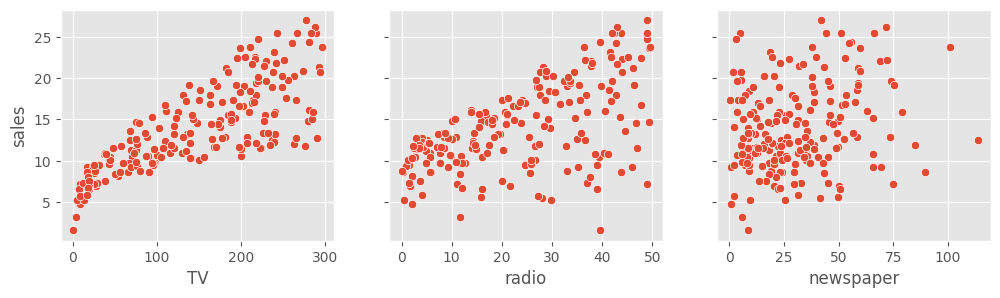

In [28]:
fig, ax = plt.subplots( 1, 3, figsize=(12,3), sharey=True )
for i, x in enumerate(['TV', 'radio', 'newspaper']):
    sns.scatterplot( data=adv_data, x=x, y="sales", ax=ax[i] )

Fit a model without interactions:

In [29]:
adv_model1 = bmb.Model( "sales ~ TV + radio + newspaper", data=adv_data, family="gaussian" )
adv_trace1 = adv_model1.fit(draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, TV, radio, newspaper]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 7 seconds.


In [30]:
pm.summary( adv_trace1 )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.935,0.313,2.340,3.519,0.003,0.002,12734.0,6441.0,1.0
TV,0.046,0.001,0.043,0.048,0.000,0.000,10980.0,6289.0,1.0
newspaper,-0.001,0.006,-0.012,0.010,0.000,0.000,7955.0,6714.0,1.0
radio,0.188,0.009,0.172,0.205,0.000,0.000,8518.0,6859.0,1.0
sigma,1.696,0.087,1.538,1.861,0.001,0.001,11365.0,6361.0,1.0


newspaper is not significant at the 94% level (HDI includes zero).

$R^2$ and RMSE:

In [31]:
adv_model1.predict(adv_trace1, kind="response")
ypred = az.extract( adv_trace1.posterior_predictive ).sales.values.T
ytrue = adv_data.sales.values
pm.r2_score( ytrue, ypred )

r2        0.826670
r2_std    0.015998
dtype: float64

In [32]:
np.sqrt( np.mean( (ypred-ytrue)**2 ) )

2.393714238777284

Contour plot to motivate interaction:

Text(0, 0.5, 'radio')

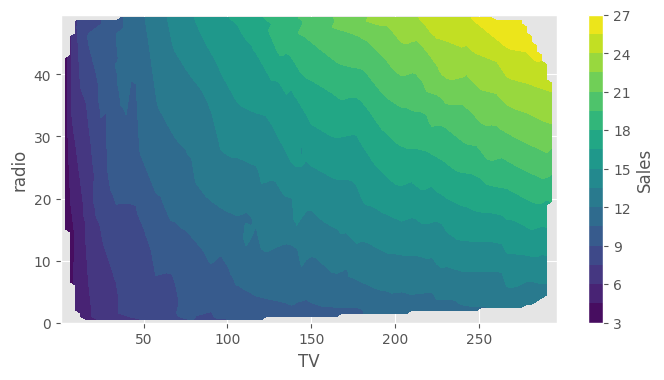

In [33]:
from scipy.interpolate import griddata

# Variables for TV, radio and sales
X = adv_data['TV']
Y = adv_data['radio']
Z = adv_data['sales']

# Create grid data for contour
xi = np.linspace(X.min(), X.max(), 100)
yi = np.linspace(Y.min(), Y.max(), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolate sales values on the grid
zi = griddata((X, Y), Z, (xi, yi), method='linear')

# Plot contour
plt.figure( figsize=(8,4) )
plt.contourf(xi, yi, zi, levels=20, cmap='viridis')
plt.colorbar(label='Sales')
plt.xlabel('TV')
plt.ylabel('radio')

Model with interaction:

In [34]:
adv_model2 = bmb.Model( "sales ~ TV + radio + TV:radio", data=adv_data, family="gaussian" )
adv_trace2 = adv_model2.fit(draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, TV, radio, TV:radio]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 11 seconds.


In [35]:
pm.summary( adv_trace2 )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,6.749,0.252,6.278,7.235,0.004,0.003,3221.0,4353.0,1.0
TV,0.019,0.002,0.016,0.022,0.000,0.000,3034.0,4185.0,1.0
TV:radio,0.001,0.000,0.001,0.001,0.000,0.000,2806.0,3852.0,1.0
radio,0.029,0.009,0.012,0.046,0.000,0.000,2986.0,4044.0,1.0
sigma,0.950,0.048,0.857,1.040,0.001,0.000,6653.0,4642.0,1.0


Interaction between TV and radio is significant.

Change in $R^2$ and RMSE:

In [36]:
adv_model2.predict(adv_trace2, kind="response")
ypred = az.extract( adv_trace2.posterior_predictive ).sales.values.T
ytrue = adv_data.sales.values
pm.r2_score( ytrue, ypred )

r2        0.938222
r2_std    0.006154
dtype: float64

In [37]:
np.sqrt( np.mean( (ytrue-ypred)**2 ) )

1.3397042850987047